In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Input
dataset_mat = loadmat('Source_Target_BZ_DG_GG_down_sample.mat')
source_dataset_raw=np.vstack((dataset_mat['target_BZ_down_sample_points'],
                              dataset_mat['target_DG_down_sample_points'],
                              dataset_mat['target_GG_down_sample_points']))
target_dataset_raw=np.vstack((dataset_mat['Source_BZ_down_sample_points'],
                              dataset_mat['Source_DG_down_sample_points'],
                              dataset_mat['Source_GG_down_sample_points'])).transpose(0,2,1)

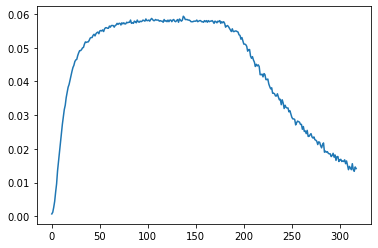

In [3]:
from matplotlib import pyplot as plt

plt.plot(range(318), source_dataset_raw[2,:,4])

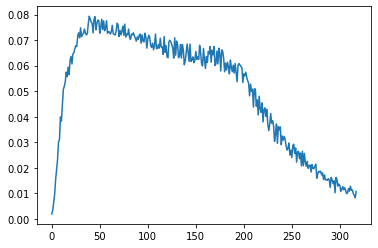

In [4]:
plt.plot(range(318), target_dataset_raw[2,:,4])

In [5]:
# Labels
y_source=np.hstack((0*np.ones(160),1*np.ones(160),2*np.ones(160))).astype(np.int64)
y_target=np.hstack((0*np.ones(50),1*np.ones(50),2*np.ones(50))).astype(np.int64)

In [6]:
print(source_dataset_raw.shape)
print(target_dataset_raw.shape)
print(y_source.shape)
print(y_target.shape)

(480, 318, 16)
(150, 318, 16)
(480,)
(150,)


### DRCA

In [7]:
class DRCA():
    '''
    The DRCA Class
    '''
    def __init__(self, n_components = 2,alpha = None, mode = 'raw'):
        '''
        The function to initialize the DRCA class
        :param n_components: The intended dimensionality of projection hyperplane smaller than the initial dimensionality
        :param alpha: weighting factor for target domain data within class scatter
        :param mode: the mode of DRCA:
            'raw': consider source domain data (S) and target domain data (T) as two groups
            'number': consider type-specific source domain data and target domain data based on the average number of cases in S and T
            'mean': equal weights for each class
        '''
        self.mode = mode
        self.Sw_s = None
        self.Sw_t = None
        self.mu_s = None
        self.mu_t = None
        self.alpha = alpha
        self.D_tilde = n_components
    pass

    def fit(self, Xs, Xt, Ys=None, Yt = None):
        '''
        This function fit the DRCA model with the data and labels given by users
        :param Xs: the feature matrix of shape (Ns, D) in source domain, np.array
        :param Xt: the feature matrix of shape (Nt, D) in target domain, np.array
        :param Ys: the label of the data of shape (Ns,) in source domain, np.array, int
        :param Yt: the label of the data of shape (Nt,) in target domain, np.array, int
        '''
        ### --- Summarize statistics --- ###
        if self.mode != 'raw':
            Ys = Ys.reshape(-1,) #we need to use Y and make sure the Y is the intended form
            Yt = Yt.reshape(-1,)
        Ns = Xs.shape[0]
        Nt = Xt.shape[0]
        D = Xs.shape[1]
        
        ### --- Within-domain scatter --- ###
        self.mu_s = np.mean(Xs,axis=0,keepdims=True) #1*D
        self.mu_t = np.mean(Xt,axis=0,keepdims=True)
        self.Sw_s = (Xs - self.mu_s).T @ (Xs - self.mu_s) #D*D
        self.Sw_t = (Xt - self.mu_t).T @ (Xt - self.mu_t) #D*D
        if self.alpha == None:
            self.alpha = Ns/Nt
        self.nominator = self.Sw_s + self.Sw_t * self.alpha
        
        ### --- Eliminate sensor drifts --- ###
        if self.mode == 'raw': #S and T as two entities
            self.denominator = (self.mu_s - self.mu_t).T @ (self.mu_s-self.mu_t) #D*D
        elif self.mode == 'number': #Focus on the same classes appeared in target domain
            Kt = np.unique(Yt).shape[0] #Assume that the target domain classes are fewer 
            self.denominator = np.empty((D,D))
            for i in range(Kt):
                Ns = np.mean(Ys==Kt[i])
                Nt = np.mean(Yt==Kt[i])
                N = 0.5*(self.Ns+self.Nt)#self. ???????????????????
                mu_s_matrix = np.mean(Xs[Ys==Kt[i],:],axis=0,keepdims=True)
                mu_t_matrix = np.mean(Xt[Yt==Kt[i],:],axis=0,keepdims=True)
                Sb_matrix = (self.mu_s_matrix-self.mu_t_matrix).T @ (self.mu_s_matrix-self.mu_t_matrix)
                self.denomiator += N * Sb_matrix
        elif self.mode == 'mean': #Equal weights for every class
            Kt = np.unique(Yt).shape[0] #Assume that the target domain classes are fewer 
            self.denominator = np.empty((D,D))
            for i in range(Kt):
                mu_s_matrix = np.mean(Xs[Ys==Kt[i],:],axis=0,keepdims=True)#1*D
                mu_t_matrix = np.mean(Xt[Yt==Kt[i],:],axis=0,keepdims=True)#1*D
                Sb_matrix = (self.mu_s_matrix-self.mu_t_matrix).T @ (self.mu_s_matrix-self.mu_t_matrix)
                self.denomiator += Sb_matrix#D*D
        
        
        eigenValues, eigenVectors = np.linalg.eig(np.linalg.pinv(self.denominator) @ self.nominator) #D*D

        idx = np.abs(eigenValues).argsort()[::-1]  
        self.eigenValues = eigenValues[idx]
        self.eigenVectors = eigenVectors[:,idx]
        self.W = self.eigenVectors[:,0:self.D_tilde]#shape=(D,D_tilde)
    pass    
        
    def transform(self, X):
        '''
        This function use the fitted SRLDA model
        :param X: the data in np.array of shape (N,D) that needs to be projected to the lower dimension
        :return: X_tilde: the projected data in the lower dimensional space in np.array of shape (N, D_tilde)
        '''
        return np.matmul(X,self.W)   #goal:  (N,D_tilde)      (D_tilde*D)@(D*N).T     (N*D)(D*D_tilde)
    pass
    
    def fit_transform(self, Xs, Xt, Ys=None, Yt = None):
        '''
        :param Xs: the feature matrix of shape (Ns, D) in source domain, np.array
        :param Xt: the feature matrix of shape (Nt, D) in target domain, np.array
        :param Ys: the label of the data of shape (Ns,) in source domain, np.array, int
        :param Yt: the label of the data of shape (Nt,) in target domain, np.array, int '''
                                                  
        self.fit(Xs, Xt, Ys, Yt)
        return np.real(self.transform(Xs)),np.real(self.transform(Xt)) #N * D_tilde
    pass

### Spilt Dataset

In [8]:
class HerbalData(Dataset):
    def __init__(self, x_train, y_train):
        assert len(x_train) == len(y_train)
        self.x = x_train
        self.y = y_train
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [9]:
# Without DRCA
x_train, x_valid, y_train, y_valid = train_test_split(source_dataset_raw, y_source, train_size=0.7, random_state=1)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, train_size=0.5, random_state=1)
train_set = HerbalData(torch.from_numpy(x_train).to(device), torch.from_numpy(y_train).to(device))
valid_set = HerbalData(torch.from_numpy(x_valid).to(device), torch.from_numpy(y_valid).to(device))
test_set = HerbalData(torch.from_numpy(x_test).to(device), torch.from_numpy(y_test).to(device))
target_set = HerbalData(torch.from_numpy(target_dataset_raw).to(device), torch.from_numpy(y_target).to(device))

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=32)
target_dataloader = DataLoader(target_set, batch_size=32)

print("Train Set:", x_train.shape)
print("Valid Set:", x_valid.shape)
print("Test Set:", x_test.shape)
print("Target Set:", target_dataset_raw.shape)

Train Set: (336, 318, 16)
Valid Set: (72, 318, 16)
Test Set: (72, 318, 16)
Target Set: (150, 318, 16)


In [10]:
def DRCA_2D(source, target):
    '''
    Apply DRCA to 2d dataset
    '''
    pass

In [11]:
# With DRCA
# drca=DRCA(n_components=50, alpha=10)#n_components and alpha value are hyperparameters
# source_dataset_drca, target_dataset_drca = drca.fit_transform(source_dataset_raw,target_dataset_raw)


# x_train_drca, x_valid_drca, y_train_drca, y_valid_drca = train_test_split(source_dataset_drca, y_source, train_size=0.6, random_state=1)
# train_set_drca = HerbalData(torch.from_numpy(x_train_drca).to(device), torch.from_numpy(y_train_drca).to(device))
# valid_set_drca = HerbalData(torch.from_numpy(x_valid_drca).to(device), torch.from_numpy(y_valid_drca).to(device))
# test_set_drca = HerbalData(torch.from_numpy(target_dataset_drca).to(device), torch.from_numpy(y_target).to(device))

# train_dataloader_drca = DataLoader(train_set_drca, batch_size=64, shuffle=True)
# valid_dataloader_drca = DataLoader(valid_set_drca, batch_size=64, shuffle=True)
# test_dataloader_drca = DataLoader(test_set_drca, batch_size=64)

### LSTM

In [12]:
class LSTM(nn.Module):
    def __init__(self, seq_len, input_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()
        
        self.rnn = nn.LSTM(input_dim, 
                           hidden_dim, 
                           batch_first=True,
                           num_layers=n_layers, 
                           bidirectional=True, 
                           dropout=dropout)
        
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, data):
        
        # data = [batch size, seq_len, input_dim]
        
        packed_output, (hidden, cell) = self.rnn(data)
        
        #hidden = [num layers * num directions, batch size, hid dim]
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        
        #hidden = [batch size, hid dim * num directions]
        
        output = self.fc(hidden)
            
        return output

In [13]:
def train(model, train_dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_f1 = 0
    batches = len(train_dataloader)
    
    model.train()
    
    for _, batch in enumerate(train_dataloader):
        x, y = batch
        
        optimizer.zero_grad()
        
        predictions = model(x)
        
        loss = criterion(predictions, y)
        
        predictions = torch.argmax(torch.softmax(predictions, 0), dim=1)
        acc = torchmetrics.functional.accuracy(predictions, y)
        prec, recall = torchmetrics.functional.precision_recall(predictions, y, num_classes=3, average='macro')
        f1 = torchmetrics.functional.f1(predictions, y, num_classes=3, average='macro')
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_prec += prec.item()
        epoch_recall += recall.item()
        epoch_f1 += f1.item()

    return epoch_loss / batches, epoch_acc / batches, epoch_prec / batches, epoch_recall / batches, epoch_f1 / batches

In [14]:
def evaluate(model, test_dataloader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_f1 = 0
    batches = len(test_dataloader)
    
    model.eval()
    
    with torch.no_grad():
    
        for _, batch in enumerate(test_dataloader):
            x, y = batch

            predictions = model(x)
            
            loss = criterion(predictions, y)
            
            predictions = torch.argmax(torch.softmax(predictions, 0), dim=1)
            acc = torchmetrics.functional.accuracy(predictions, y)
            prec, recall = torchmetrics.functional.precision_recall(predictions, y, num_classes=3, average='macro')
            f1 = torchmetrics.functional.f1(predictions, y, num_classes=3, average='macro')

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_prec += prec.item()
            epoch_recall += recall.item()
            epoch_f1 += f1.item()
        
    return epoch_loss / batches, epoch_acc / batches, epoch_prec / batches, epoch_recall / batches, epoch_f1 / batches

### Training Model Without DRCA

In [15]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [16]:
INPUT_DIM = x_train.shape[2]
# INPUT_DIM_DRCA = x_train_drca.shape[1]
SEQ_LEN = x_train.shape[1]
HIDDEN_DIM = 256
N_LAYER = 2
OUTPUT_DIM = 3
DROPOUT = 0.1

model = LSTM(SEQ_LEN, INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYER, DROPOUT)
model.double()
model = model.to(device)
optimizer = optim.Adam(model.parameters())

# model_drca = CNN1d(INPUT_DIM_DRCA, N_FILTERS, FILTER_SIZES, STRIDES, OUTPUT_DIM, DROPOUT)
# model_drca.double()
# model_drca = model_drca.to(device)
# optimizer_drca = optim.Adam(model_drca.parameters())

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [17]:
N_EPOCHS = 30

train_loss = np.zeros(N_EPOCHS)
train_acc = np.zeros(N_EPOCHS)
train_prec = np.zeros(N_EPOCHS)
train_recall = np.zeros(N_EPOCHS)
train_f1 = np.zeros(N_EPOCHS)

valid_loss = np.zeros(N_EPOCHS)
valid_acc = np.zeros(N_EPOCHS)
valid_prec = np.zeros(N_EPOCHS)
valid_recall = np.zeros(N_EPOCHS)
valid_f1 = np.zeros(N_EPOCHS)


best_valid_loss = float('inf')

for i in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss[i], train_acc[i], train_prec[i], train_recall[i], train_f1[i] = train(model, train_dataloader, optimizer, criterion)
    valid_loss[i], valid_acc[i], valid_prec[i], valid_recall[i], valid_f1[i] = evaluate(model, valid_dataloader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss[i] < best_valid_loss:
        best_valid_loss = valid_loss[i]
        torch.save(model.state_dict(), 'lstm-downsample.pt')
    
    print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss[i]:.3f} | Train Acc: {train_acc[i]*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss[i]:.3f} |  Val. Acc: {valid_acc[i]*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 1.096 | Train Acc: 50.28%
	 Val. Loss: 1.084 |  Val. Acc: 59.38%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.992 | Train Acc: 58.52%
	 Val. Loss: 1.142 |  Val. Acc: 46.88%
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 1.015 | Train Acc: 68.47%
	 Val. Loss: 1.334 |  Val. Acc: 41.67%
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.855 | Train Acc: 59.94%
	 Val. Loss: 0.723 |  Val. Acc: 58.33%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.792 | Train Acc: 58.81%
	 Val. Loss: 0.883 |  Val. Acc: 59.38%
Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.772 | Train Acc: 62.50%
	 Val. Loss: 0.804 |  Val. Acc: 61.46%
Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.749 | Train Acc: 61.65%
	 Val. Loss: 0.885 |  Val. Acc: 56.25%
Epoch: 08 | Epoch Time: 0m 4s
	Train Loss: 0.767 | Train Acc: 61.93%
	 Val. Loss: 0.781 |  Val. Acc: 63.54%
Epoch: 09 | Epoch Time: 0m 4s
	Train Loss: 0.718 | Train Acc: 63.64%
	 Val. Loss: 0.872 |  Val. Acc: 60.42%
Epoch: 10 | Epoch Time: 0m 4

## Analysis

In [26]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

def predict(model, x):
    x = torch.from_numpy(x).to(device)
    with torch.no_grad():
        return torch.argmax(torch.softmax(model(x), 0), dim=1).cpu().detach().numpy()

def confusion_matrix_plot(y_pred, y_true):
    cm = confusion_matrix(y_pred, y_true, normalize='true')
    normalize = True
    cmap = 'RdPu'
    classes = [0, 1, 2]
    title = 'cofusion matrix'
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax = ax)
    ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), xticklabels = classes, yticklabels = classes, ylabel = 'True label', xlabel = 'Predicted label', title = title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right', rotation_mode = 'anchor')
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha = 'center', va = 'center', color = 'white' if cm[i,j] > thresh else 'black')
            fig.tight_layout()

def metric_epoch(train_loss, valid_loss, train_f1, valid_f1):
    x = range(0, len(train_loss))
    plt.figure(figsize=(14,3))
    grid = plt.GridSpec(3, 2, wspace=0.5, hspace=0.5)
    plt.subplot(grid[:,0])
    plt.plot(x, train_f1, color="r", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Train F1 score')
    plt.plot(x, valid_f1, color="b", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Valid F1 score')
    plt.legend()
    plt.title('F1 score vs epoches')
    plt.xlabel('epoches')
    plt.ylabel('F1 score')
    plt.subplot(grid[:,1])
    plt.plot(x, train_loss, color="red", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Train Loss')
    plt.plot(x, valid_loss, color="blue", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Valid Loss')
    plt.legend()
    plt.title('Loss vs epoches')
    plt.xlabel('epoches')
    plt.ylabel('Loss')
    plt.show()

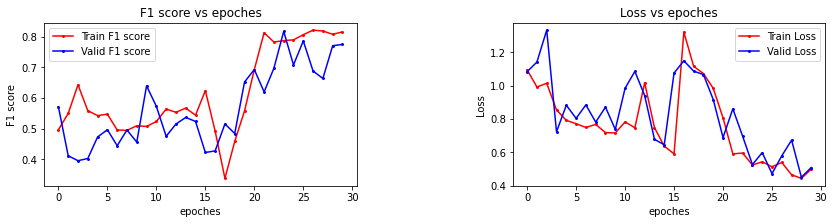

In [27]:
metric_epoch(train_loss, valid_loss, train_f1, valid_f1)

### Test Set

In [20]:
model.load_state_dict(torch.load('lstm-downsample.pt'))

test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate(model, test_dataloader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Prec: {test_prec*100:.2f}% | Test Recall: {test_recall*100:.2f}% | Test F1: {test_f1*100:.2f}%')

Test Loss: 0.522 | Test Acc: 87.50% | Test Prec: 88.86% | Test Recall: 88.36% | Test F1: 87.26%


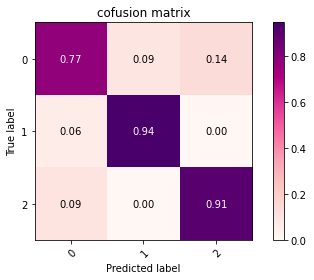

In [21]:
confusion_matrix_plot(predict(model, x_test), y_test)

### Target Set

In [22]:
model.load_state_dict(torch.load('lstm-downsample.pt'))

test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate(model, target_dataloader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Prec: {test_prec*100:.2f}% | Test Recall: {test_recall*100:.2f}% | Test F1: {test_f1*100:.2f}%')

Test Loss: 3.972 | Test Acc: 29.55% | Test Prec: 30.38% | Test Recall: 15.28% | Test F1: 17.19%


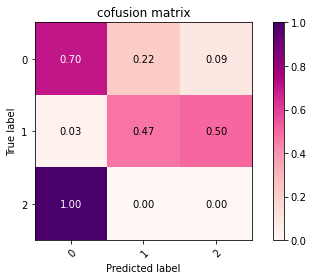

In [23]:
confusion_matrix_plot(predict(model, target_dataset_raw), y_target)

### Training Model With DRCA

In [24]:
# N_EPOCHS = 30

# best_valid_loss = float('inf')

# for epoch in range(N_EPOCHS):

#     start_time = time.time()
    
#     train_loss, train_acc = train(model_drca, train_dataloader_drca, optimizer_drca, criterion)
#     valid_loss, valid_acc = evaluate(model_drca, valid_dataloader_drca, criterion)
    
#     end_time = time.time()

#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model_drca.state_dict(), 'cnn-drca.pt')
    
#     print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [25]:
# model_drca.load_state_dict(torch.load('cnn-drca.pt'))

# test_loss, test_acc = evaluate(model_drca, test_dataloader_drca, criterion)
# print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')